In [1]:
import csv
import random
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from statistics import mean
from datetime import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Run once

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")

# print("Path to dataset files:", path)

In [3]:
# !mv /home/sd8/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2 ./netflix-prize-data

In [4]:
# # Process Netflix dataset and save to CSV
# train_filename = "./data-created/netflix_ratings_train.csv"
# val_filename = "./data-created/netflix_ratings_val.csv"
# test_filename = "./data-created/netflix_ratings_test.csv"

# with open(train_filename, "w", newline="") as train_file, \
#     open(val_filename, "w", newline="") as val_file, \
#     open(test_filename, "w", newline="") as test_file:

#     train_writer = csv.writer(train_file)
#     val_writer = csv.writer(val_file)
#     test_writer = csv.writer(test_file)

#     # Write headers
#     train_writer.writerow(["movie_id", "user_id", "date", "rating"])
#     val_writer.writerow(["movie_id", "user_id", "date", "rating"])
#     test_writer.writerow(["movie_id", "user_id", "date", "rating"])

#     for j in range(1, 5):
#        print(f'processing file {j}')
#        with open(f'./netflix-prize-data/combined_data_{j}.txt', 'r') as f:
#           movie_id = None

#           for line in f:
#              if line.endswith(':\n'):
#                 movie_id = int(line.split(':')[0])
#              else:
#                 user, rating, date = line.strip().split(',')
#                 rand = random.random()
#                 if rand < 0.8:
#                     train_writer.writerow([movie_id, int(user), datetime.strptime(date, "%Y-%m-%d").date(), int(rating)])
#                 elif rand < 0.9:
#                     val_writer.writerow([movie_id, int(user), datetime.strptime(date, "%Y-%m-%d").date(), int(rating), ])
#                 else:
#                     test_writer.writerow([movie_id, int(user), datetime.strptime(date, "%Y-%m-%d").date(), int(rating), ])

# print(f"CSV files created successfully!")


In [5]:
# train_data = pd.read_csv('./netflix_ratings_train.csv')
# users = set(train_data['user_id'].unique())
# movies = set(train_data['movie_id'].unique())
# del train_data
# val_data = pd.read_csv('./netflix_ratings_val.csv')
# users.update(val_data['user_id'].unique())
# movies.update(val_data['movie_id'].unique())
# del val_data
# test_data = pd.read_csv('./netflix_ratings_test.csv')
# users.update(test_data['user_id'].unique())
# movies.update(test_data['movie_id'].unique())
# del test_data

# # Create a mapping from user_id to index
# user_to_index = {user_id: index for index, user_id in enumerate(users, 1)}
# # Create a mapping from index to user_id
# index_to_user = {index: user_id for user_id, index in user_to_index.items()}

# # create a mapping from movie_id to index
# movie_to_index = {movie_id: index for index, movie_id in enumerate(movies, 1)}
# # Create a mapping from index to movie_id
# index_to_movie = {index: movie_id for movie_id, index in movie_to_index.items()}

# # save the mappings to CSV files
# user_to_index_df = pd.DataFrame(list(user_to_index.items()), columns=['user_id', 'user_index'])
# user_to_index_df.to_csv('./netflix-prize-data/user_to_index.csv', index=False)
# movie_to_index_df = pd.DataFrame(list(movie_to_index.items()), columns=['movie_id', 'movie_index'])
# movie_to_index_df.to_csv('./netflix-prize-data/movie_to_index.csv', index=False)

In [6]:
# write_file = "./data-created/movies.csv"
# read_file = "./netflix-prize-data/movie_titles.csv"
# # Read the CSV file
# with open(read_file, 'r') as file, open(write_file, 'w', newline='') as f:
#     reader = csv.reader(file)
#     writer = csv.writer(f)
#     # Write the header
#     writer.writerow(["movie_id", "release_year", "title"])

#     for row in reader:
#         movie_id = int(row[0])
#         if row[1] == 'NULL':
#             release_year = None
#         else:
#             release_year = int(row[1])
#         title = ', '.join(row[2:])
#         # Write the row to the new CSV file
#         writer.writerow([movie_id, release_year, title])

# Netflix Model

In [7]:
def load_mappings(user_to_index_path, movie_to_index_path):
    user_to_index_df = pd.read_csv(user_to_index_path)
    movie_idx_to_name_df = pd.read_csv(movie_to_index_path)

    user_to_index = dict(zip(user_to_index_df['user_id'], user_to_index_df['user_index']))
    movies_dict = {}

    for i in range(len(movie_idx_to_name_df)):
        x = movie_idx_to_name_df.iloc[i]
        movies_dict[x['movie_id']] = (x['title'], x['release_year'])
    return user_to_index, movies_dict

In [8]:
# Example usage
user_to_index, movies_dict, = load_mappings('./data-created/user_to_index.csv', './data-created/movies.csv')
user_to_index = {uid: idx - 1 for uid, idx in user_to_index.items()}
movie_to_index = {mid: mid - 1 for mid, _ in movies_dict.items()}


In [9]:
min_year = 2025
max_year = 0
for key, value in movies_dict.items():
    min_year = min(min_year, value[1])
    max_year = max(max_year, value[1])
min_year, max_year

(1896.0, 2005.0)

In [10]:
class NetflixDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.user_mapping = user_to_index  # Assumed to be defined
        self.movie_mapping = movie_to_index  # Assumed to be defined
        self.movies = movies_dict  # Assumed to be defined
        self.num_users = len(self.user_mapping)
        self.num_movies = len(self.movie_mapping)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        movie_id = torch.tensor(self.movie_mapping[row["movie_id"]], dtype=torch.long)
        user_id = torch.tensor(self.user_mapping[row["user_id"]], dtype=torch.long)
        rating = torch.tensor(row["rating"]-1, dtype=torch.float32)

        release_date = self.movies[row["movie_id"]][1] if not np.isnan(self.movies[row["movie_id"]][1]) else int(1896)
        user_date = datetime.strptime(row["date"], "%Y-%m-%d").date()

        day = torch.tensor(user_date.day - 1, dtype=torch.long)
        month = torch.tensor(user_date.month - 1, dtype=torch.long)
        year = torch.tensor((user_date.year - min_year) / (max_year - min_year), dtype=torch.float32)
        weekday = torch.tensor(user_date.weekday(), dtype=torch.long)
        release_date = torch.tensor((release_date - min_year) / (max_year - min_year), dtype=torch.float32)

        return user_id, day, month, year, weekday, movie_id, release_date, rating

In [11]:
import torch
import torch.nn as nn

class UserTower(nn.Module):
    def __init__(self, num_users, embedding_dim=64):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.day_embedding = nn.Embedding(31, embedding_dim // 2)  # Smaller embedding for day
        self.month_embedding = nn.Embedding(12, embedding_dim // 2)
        self.weekday_embedding = nn.Embedding(7, embedding_dim // 2)
        
        # MLP to process user features
        self.user_mlp = nn.Sequential(
            nn.Linear(embedding_dim + 3 * (embedding_dim // 2) + 1, 128),  # Concatenated size + year
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, user_id, day, month, year, weekday):
        user_emb = self.user_embedding(user_id)
        day_emb = self.day_embedding(day)
        month_emb = self.month_embedding(month)
        weekday_emb = self.weekday_embedding(weekday)
        year_emb = year.reshape(-1, 1)  # (batch_size, 1)
        
        # Concatenate all user-related features
        user_features = torch.cat([user_emb, day_emb, month_emb, weekday_emb, year_emb], dim=1)
        return self.user_mlp(user_features)

class MovieTower(nn.Module):
    def __init__(self, num_movies, embedding_dim=64):
        super().__init__()
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        
        # MLP to process movie features
        self.movie_mlp = nn.Sequential(
            nn.Linear(embedding_dim + 1, 128),  # Movie embedding + release_date
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, movie_id, release_date):
        movie_emb = self.movie_embedding(movie_id)
        release_date_emb = release_date.reshape(-1, 1)
        
        # Concatenate movie features
        movie_features = torch.cat([movie_emb, release_date_emb], dim=1)
        return self.movie_mlp(movie_features)

In [12]:
class NetflixModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=64):
        super().__init__()
        self.user_tower = UserTower(num_users, embedding_dim)
        self.movie_tower = MovieTower(num_movies, embedding_dim)
        
        # Fusion MLP to predict rating
        self.fusion_mlp = nn.Sequential(
            nn.Linear(2 * embedding_dim, 128),  # Concatenated user and movie embeddings
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Output a single scalar for regression
        )

    def forward(self, user_id, day, month, year, weekday, movie_id, release_date):
        user_vec = self.user_tower(user_id, day, month, year, weekday)
        movie_vec = self.movie_tower(movie_id, release_date)
        
        # Concatenate user and movie vectors
        # combined = torch.cat([user_vec, movie_vec], dim=1)
        # rating_pred = self.fusion_mlp(combined).squeeze(1)  # (batch_size,)
        # return torch.clamp(rating_pred, min=1.0, max=5.0)  # Constrain to [1, 5]
        # return rating_pred

        result = user_vec.reshape(-1, 1, 64) @ movie_vec.reshape(-1, 64, 1)
        return result.squeeze(1).squeeze(1)

In [13]:
import torch
import torch.nn as nn

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        # Weights for ratings 1.0, 2.0, 3.0, 4.0, 5.0
        self.weights = torch.tensor(weights, dtype=torch.float32).to(device)

    def forward(self, predictions, targets):
        # Map continuous targets (1.0 to 5.0) to weight indices (0 to 4)
        target_indices = (targets - 1).long()  # Convert 1.0-5.0 to 0-4
        sample_weights = self.weights[target_indices]  # Lookup weights for each target
        # Compute weighted MSE
        squared_errors = (predictions - targets) ** 2
        weighted_errors = sample_weights * squared_errors
        return torch.mean(weighted_errors)

In [14]:
len(user_to_index), len(movie_to_index)

(480189, 17770)

In [15]:
# Initialize dataset with mapping
train_dataset = NetflixDataset('./data-created/netflix_ratings_train.csv')
val_dataset = NetflixDataset('./data-created/netflix_ratings_val.csv')

# Create DataLoader 
train_dataloader = DataLoader(train_dataset, batch_size=8192, shuffle=True, num_workers=10, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=8192, shuffle=True, num_workers=10, pin_memory=True)

In [16]:
# Model, optimizer, and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetflixModel(num_users=len(user_to_index), num_movies=len(movie_to_index), embedding_dim=64).to(device)
# model.load_state_dict(torch.load('./best_model.pth'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Weighted los
weights = [1/0.05, 1/0.10, 1/0.29, 1/0.34, 
1/0.23]  # Inverse frequency
# weights = [3, 2, 1.1, 1, 1.5]
# weights = [6.9, 3.4, 1.2, 1, 1.5]

# criterion = torch.nn.MSELoss()  # Use standard MSE for now
criterion = WeightedMSELoss(weights)
criterion_val = torch.nn.MSELoss(reduction='mean')  # For RMSE calculation
# criterion = torch.nn.MSELoss(reduction='mean')  # For RMSE calculation
# criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device), reduction='mean')  # For CrossEntropyLoss
# criterion_val = torch.nn.CrossEntropyLoss(reduction='mean')  # For CrossEntropyLoss

# Training loop
num_epochs = 40
best_val_loss = float('inf')



In [17]:
@torch.no_grad()
def val_loss():
    model.eval()
    val_loss_agg = []
    for batch in val_dataloader:
        user_ids, days, months, years, weekdays, movie_ids, release_dates, ratings = batch
        predictions = model(
            user_ids.to(device), days.to(device), months.to(device), years.to(device),
            weekdays.to(device), movie_ids.to(device), release_dates.to(device)
        )
        loss = criterion_val(predictions, ratings.to(device))
        val_loss_agg.append(loss.item())
    avg_val_loss = mean(val_loss_agg)
    print(f'The val loss is {avg_val_loss}')
    model.train()
    return avg_val_loss

for epoch in range(num_epochs):
    model.train()
    loss_agg = []
    for i, batch in enumerate(train_dataloader):
        user_ids, days, months, years, weekdays, movie_ids, release_dates, ratings = batch
        optimizer.zero_grad()
        predictions = model(
            user_ids.to(device), days.to(device), months.to(device), years.to(device),
            weekdays.to(device), movie_ids.to(device), release_dates.to(device)
        )
        loss = criterion(predictions, ratings.to(device))
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.item())
    
    avg_train_loss = mean(loss_agg)
    print(f'The train loss after epoch {epoch + 1} is {avg_train_loss}')
    
    curr_val_loss = val_loss()
    if curr_val_loss < best_val_loss:
        best_val_loss = curr_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Best model saved at epoch {epoch + 1}')
    
    # Save the last epoch model
    torch.save(model.state_dict(), 'last_model.pth')
    print(f'Last model saved at epoch {epoch + 1}')
    print('-----------------')

The train loss after epoch 1 is 5.604732651284355
The val loss is 1.0660301360446647
Best model saved at epoch 1
Last model saved at epoch 1
-----------------
The train loss after epoch 2 is 5.041057176647305
The val loss is 1.0346904987227945
Best model saved at epoch 2
Last model saved at epoch 2
-----------------
The train loss after epoch 3 is 4.843932864013146
The val loss is 0.9736578325576285
Best model saved at epoch 3
Last model saved at epoch 3
-----------------
The train loss after epoch 4 is 4.7212338428619764
The val loss is 0.9888444728451039
Last model saved at epoch 4
-----------------
The train loss after epoch 5 is 4.658030633810742
The val loss is 0.9794094272036813
Last model saved at epoch 5
-----------------
The train loss after epoch 6 is 4.609532264422583
The val loss is 0.9548715771264726
Best model saved at epoch 6
Last model saved at epoch 6
-----------------
The train loss after epoch 7 is 4.568777950801556
The val loss is 0.9640878293702733
Last model saved

In [18]:
del train_dataset
del val_dataset
del model
del train_dataloader
del val_dataloader

In [19]:
model = NetflixModel(len(user_to_index), len(movie_to_index)).to(device)
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_6695/1584893429.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [20]:
def distance(preds, targets):
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    return np.sqrt(np.sum((preds - targets) ** 2))

In [21]:
import math

# Load the test dataset
test_dataset = NetflixDataset('./data-created/netflix_ratings_test.csv')
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True, num_workers=8)

# Function to calculate RMSE
def calculate_rmse(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            user_ids, days, months, years, weekdays, movie_ids, release_dates, ratings = batch
            predictions = model(
            user_ids.to(device), days.to(device), months.to(device), years.to(device),
            weekdays.to(device), movie_ids.to(device), release_dates.to(device)
        )
            # predictions = distance(user_logits, movie_logits)
            for pred, rate in zip(predictions, ratings):
                print(pred.cpu(), rate)
            loss = criterion(predictions, ratings.to(device))
            total_loss += loss.item() * len(ratings)
            total_samples += len(ratings)
            break

#     rmse = math.sqrt(total_loss / total_samples)
#     return rmse

# # Calculate RMSE on the test dataset
# test_rmse = calculate_rmse(model, test_dataloader, criterion)
# print(f"Test RMSE: {test_rmse}")

In [22]:
calculate_rmse(model, test_dataloader, criterion)

tensor(1.8846) tensor(3.)
tensor(2.3458) tensor(2.)
tensor(3.8162) tensor(4.)
tensor(2.6532) tensor(3.)
tensor(1.9093) tensor(2.)
tensor(2.7527) tensor(4.)
tensor(1.8801) tensor(2.)
tensor(2.7758) tensor(3.)
tensor(2.7812) tensor(3.)
tensor(1.9776) tensor(0.)
tensor(1.8818) tensor(4.)
tensor(2.2373) tensor(3.)
tensor(2.5592) tensor(2.)
tensor(3.6052) tensor(4.)
tensor(1.8224) tensor(1.)
tensor(2.9986) tensor(4.)
tensor(1.1088) tensor(2.)
tensor(2.8784) tensor(3.)
tensor(1.9698) tensor(4.)
tensor(2.2360) tensor(3.)
tensor(1.9165) tensor(2.)
tensor(2.3398) tensor(4.)
tensor(1.5048) tensor(0.)
tensor(1.1158) tensor(2.)
tensor(2.3438) tensor(3.)
tensor(3.7138) tensor(3.)
tensor(1.6828) tensor(3.)
tensor(1.3964) tensor(1.)
tensor(1.5772) tensor(1.)
tensor(2.3780) tensor(3.)
tensor(2.3563) tensor(2.)
tensor(2.8092) tensor(3.)
tensor(1.6928) tensor(2.)
tensor(2.0953) tensor(3.)
tensor(1.9649) tensor(1.)
tensor(1.9504) tensor(3.)
tensor(1.4122) tensor(3.)
tensor(3.3902) tensor(4.)
tensor(2.623

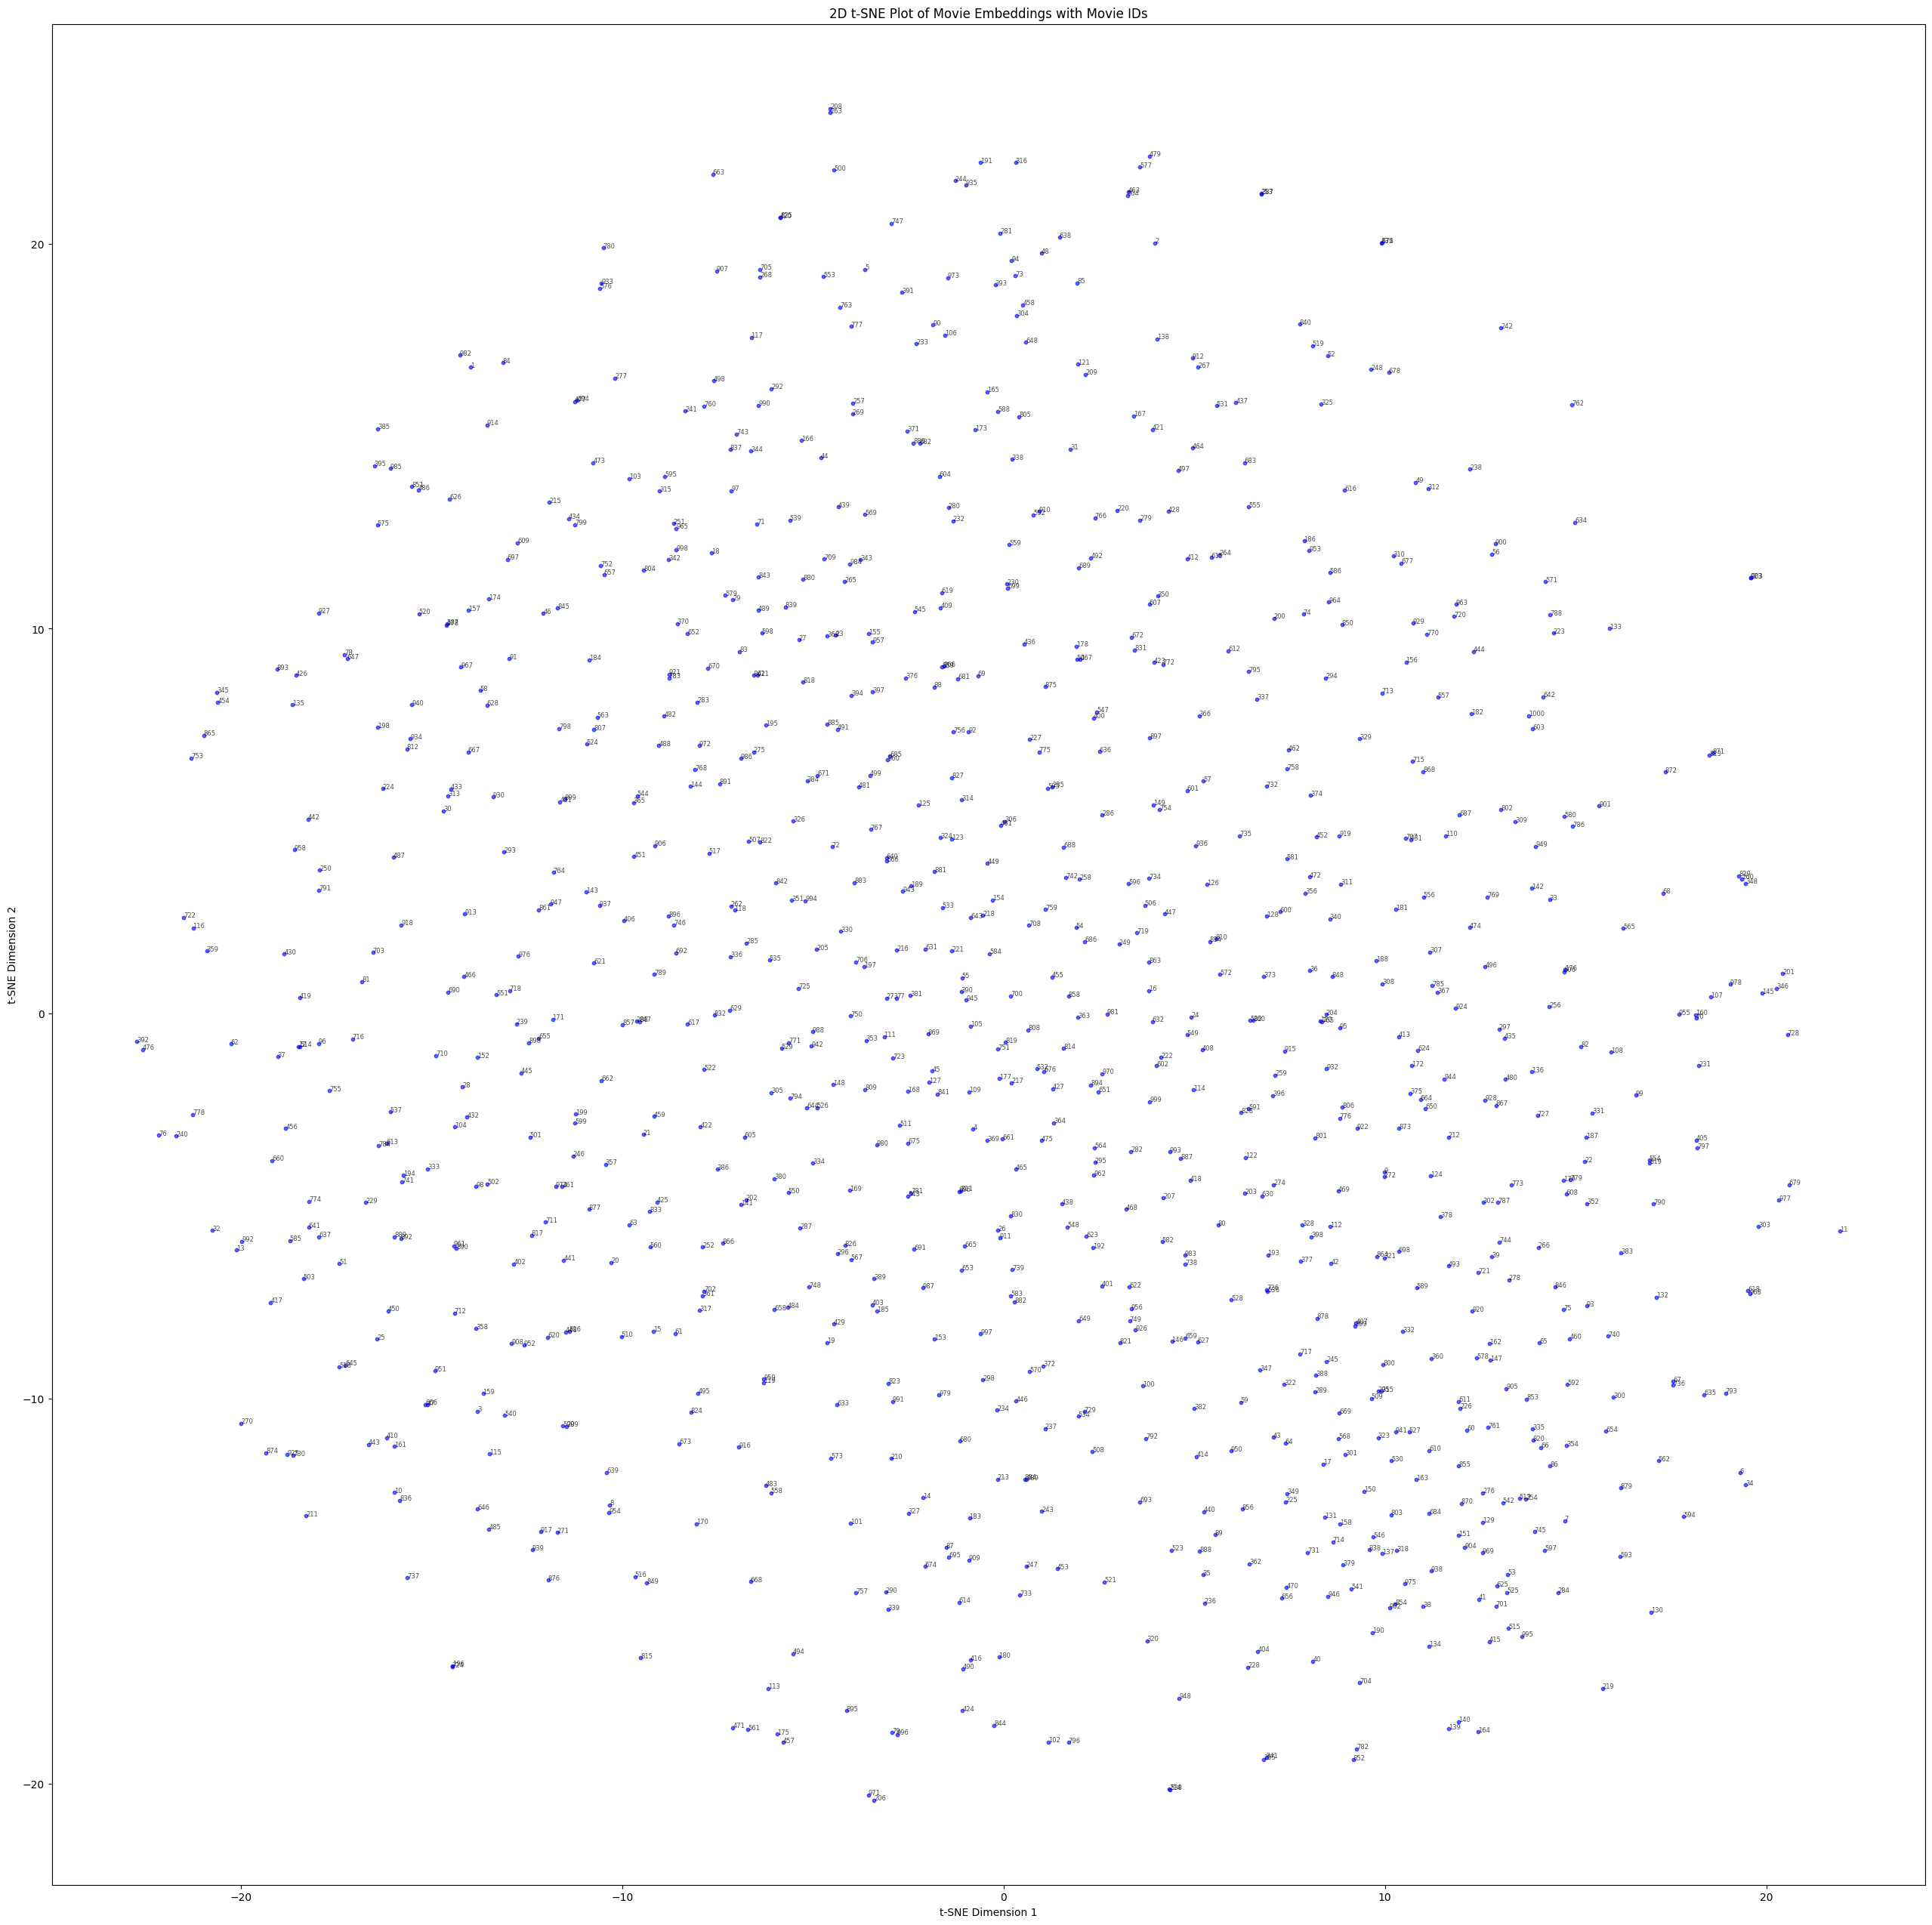

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate embeddings for all movies using the MovieTower model
movie_embeddings = []
movie_ids_list = []  # Store movie IDs for annotation
for movie_id in list(movie_to_index.keys())[:1000]:  # Limit to 100 movies for visualization
    movie_tensor = torch.tensor([movie_to_index[movie_id]], dtype=torch.long).to(device)
    release_date = torch.tensor([(movies_dict[movie_id][1] - min_year) / (max_year - min_year)], dtype=torch.float32).to(device)
    embedding = model.movie_tower.movie_embedding(movie_tensor).detach().cpu().numpy()
    movie_embeddings.append(embedding)
    movie_ids_list.append(movie_id)  # Store the movie ID

# Convert list of embeddings to a numpy array
movie_embeddings = np.vstack(movie_embeddings)

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
movie_embeddings_2d = tsne.fit_transform(movie_embeddings)

# Plot the 2D t-SNE visualization
plt.figure(figsize=(32, 32))
plt.scatter(movie_embeddings_2d[:, 0], movie_embeddings_2d[:, 1], alpha=0.6, s=10, c='blue')

# Annotate the points with movie IDs
for i, movie_id in enumerate(movie_ids_list):
    plt.annotate(str(movie_id), (movie_embeddings_2d[i, 0], movie_embeddings_2d[i, 1]), fontsize=6, alpha=0.7)

plt.title("2D t-SNE Plot of Movie Embeddings with Movie IDs")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

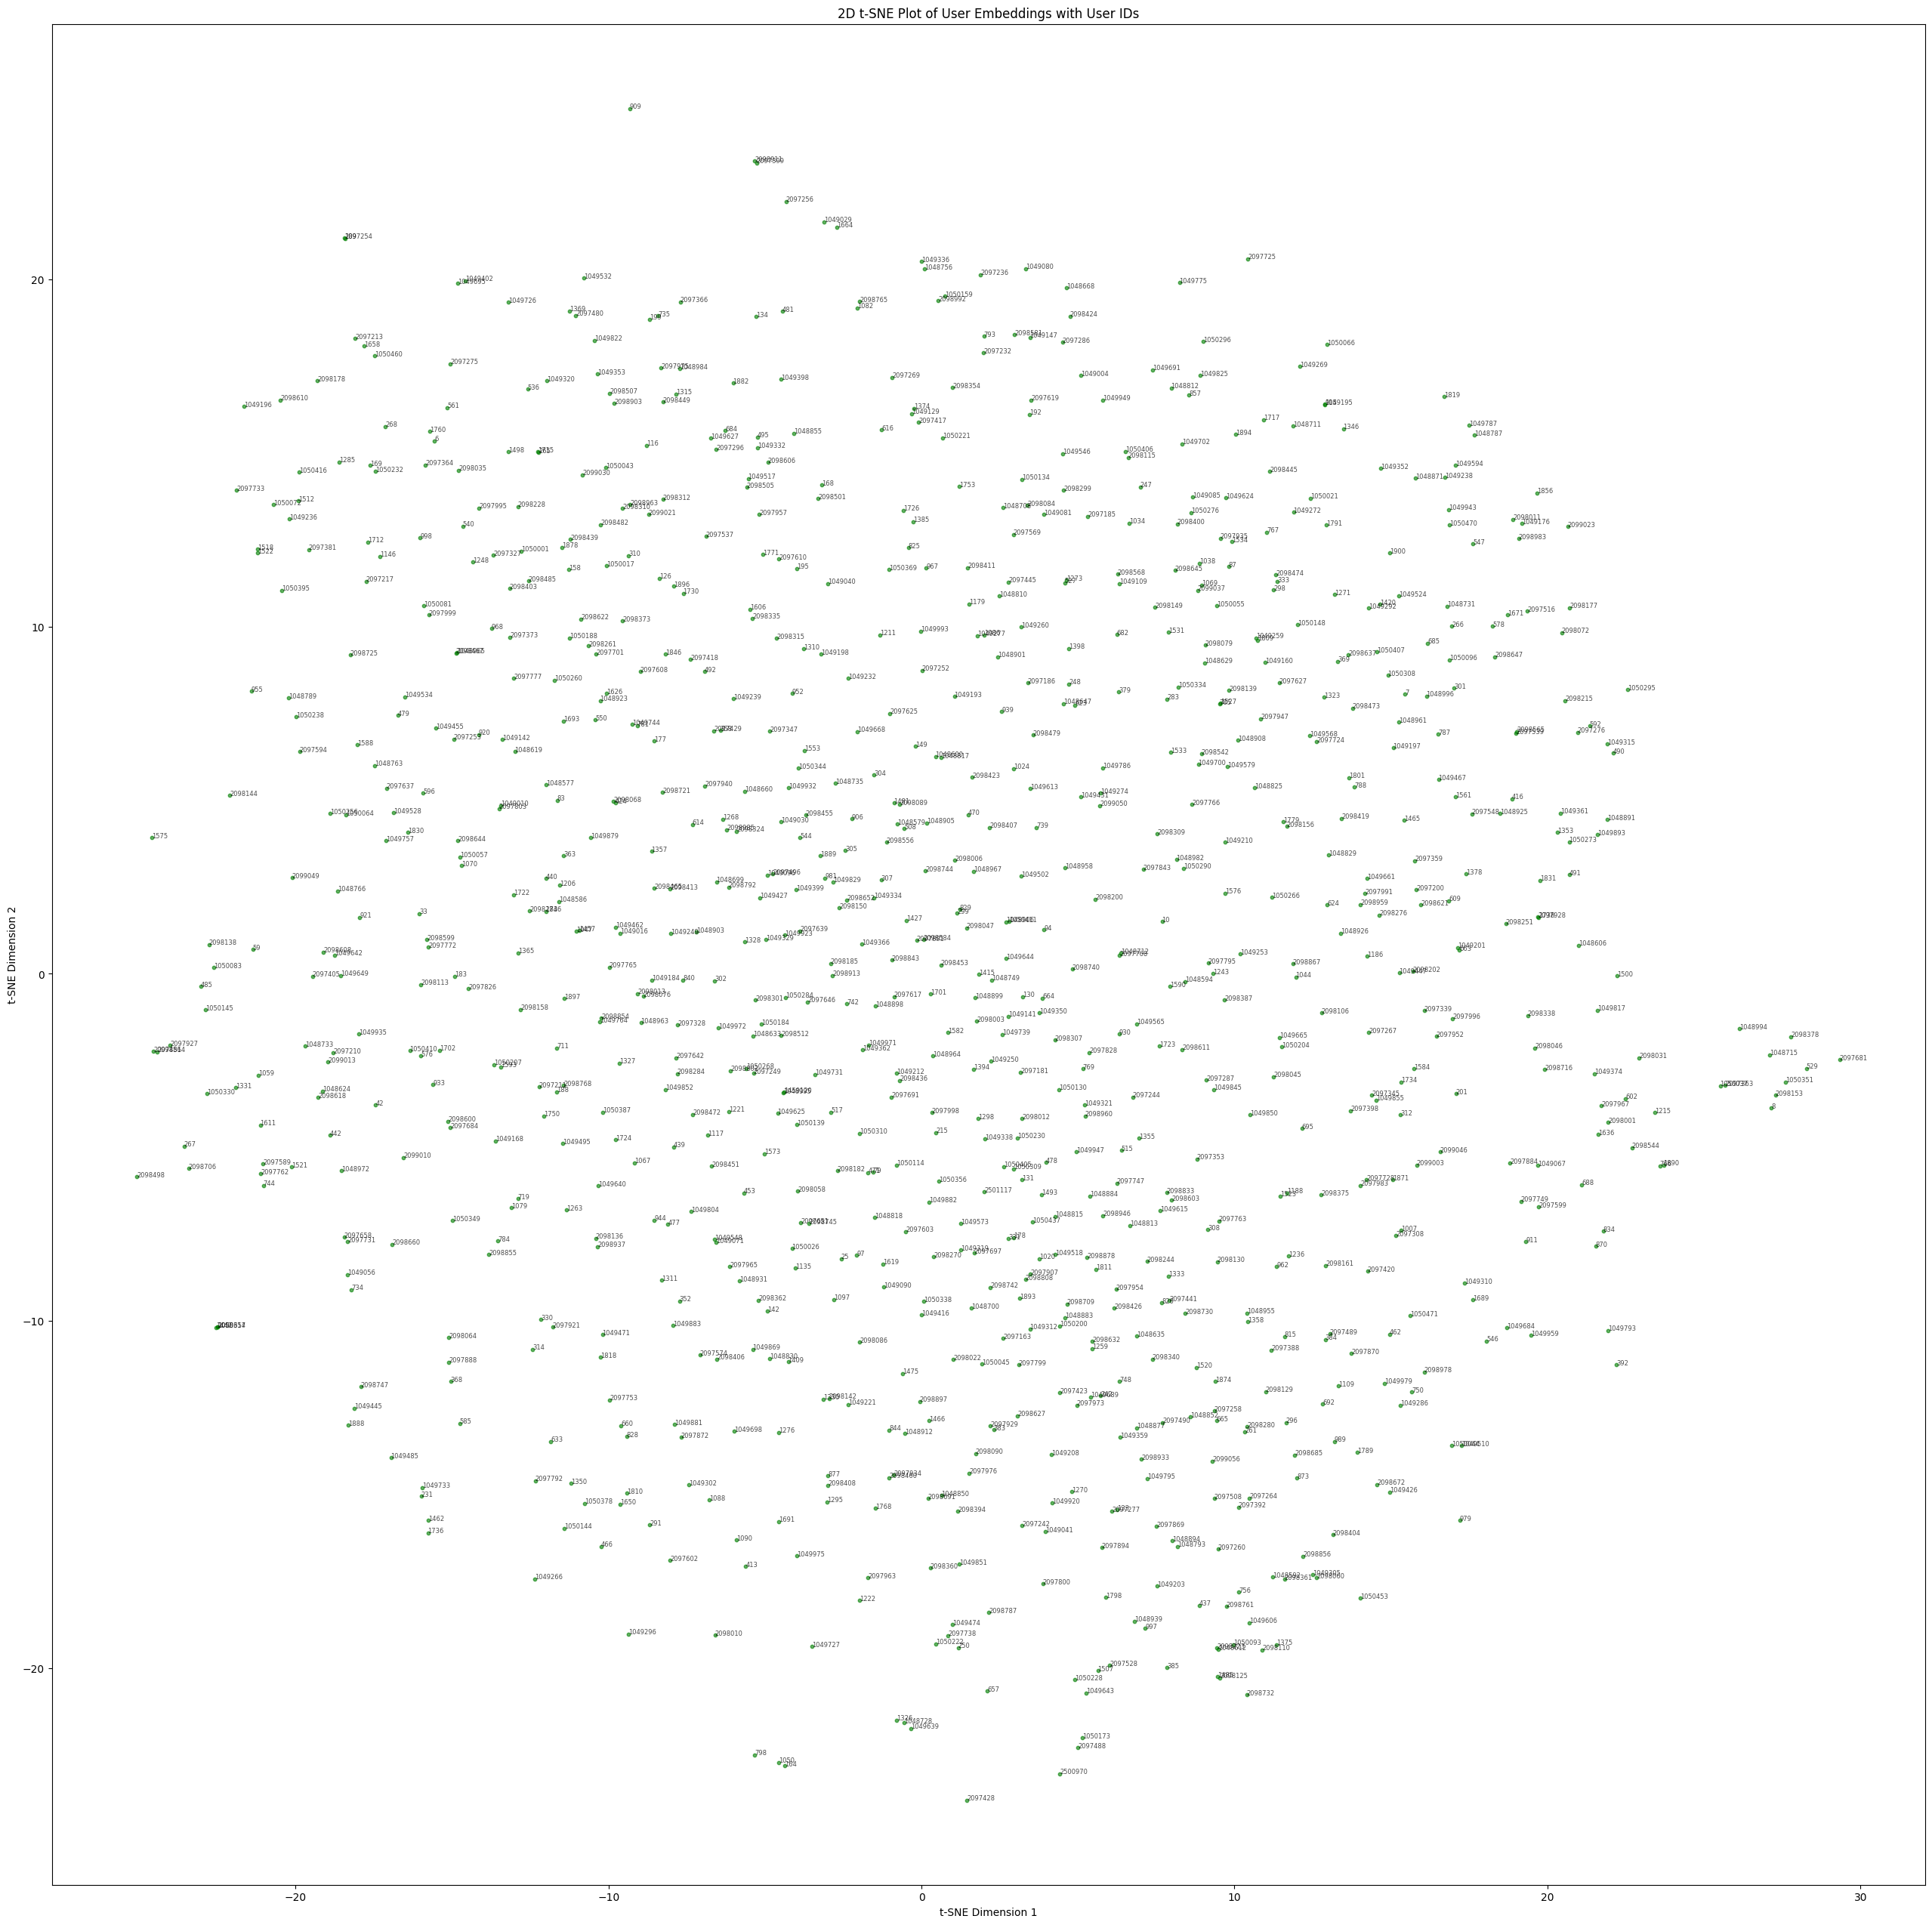

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate embeddings for all users using the UserTower model
user_embeddings = []
user_ids_list = []  # Store user IDs for annotation
for user_id in list(user_to_index.keys())[:1000]:  # Limit to 1000 users for visualization
    user_tensor = torch.tensor([user_to_index[user_id]], dtype=torch.long).to(device)
    # day = torch.tensor([0], dtype=torch.long).to(device)  # Dummy values for unused inputs
    # month = torch.tensor([0], dtype=torch.long).to(device)
    # year = torch.tensor([0.0], dtype=torch.float32).to(device)
    # weekday = torch.tensor([0], dtype=torch.long).to(device)
    embedding = model.user_tower.user_embedding(user_tensor).detach().cpu().numpy()
    user_embeddings.append(embedding)
    user_ids_list.append(user_id)  # Store the user ID

# Convert list of embeddings to a numpy array
user_embeddings = np.vstack(user_embeddings)

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
user_embeddings_2d = tsne.fit_transform(user_embeddings)

# Plot the 2D t-SNE visualization
plt.figure(figsize=(32, 32))
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], alpha=0.6, s=10, c='green')

# Annotate the points with user IDs
for i, user_id in enumerate(user_ids_list):
    plt.annotate(str(user_id), (user_embeddings_2d[i, 0], user_embeddings_2d[i, 1]), fontsize=6, alpha=0.7)

plt.title("2D t-SNE Plot of User Embeddings with User IDs")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()